In [4]:
require(data.table)
require(tidyverse)

#### old original data

In [198]:
prom.dat = fread("../dat/figdata/fig2_prom_ttest_res.csv")
# total proms for each cell type 
table(prom.dat$celltype)

head(prom.dat)


alpha  beta delta 
22449 22544 18740 

celltype,peak,gene_transcript,gene,pval,odds,FDR,padj.Bonferroni,FDR.BY,percent_open_state1,percent_open_state2,mlog10P
alpha,chr1:859052-860562,SAMD11_7,SAMD11,0.0008745605,0.5408936,0.0030385731,1,0.032096440,1.9456165,3.539157,-3.0582101
alpha,chr1:875573-875966,SAMD11_13,SAMD11,0.1372230357,0.6931602,0.1971548379,1,1.000000000,0.8907642,1.280120,-0.8625730
alpha,chr1:876931-878016,SAMD11_14,SAMD11,0.0004316489,0.4795206,0.0016642854,1,0.017579842,1.4299109,2.936747,-3.3648694
alpha,chr1:894277-895102,NOC2L_19,NOC2L,0.2061189120,0.8726655,0.2701353235,1,1.000000000,4.0318800,4.593373,-0.6858822
alpha,chr1:895801-896103,KLHL17_23,KLHL17,0.2698448417,0.8278814,0.3316704506,1,1.000000000,1.3127051,1.581325,-0.5688859
alpha,chr1:901696-902721,PLEKHN1_27,PLEKHN1,0.0001216835,0.4397100,0.0005668516,1,0.005987652,1.3127051,2.936747,-3.9147684


In [207]:
table(prom.dat %>% filter(padj.Bonferroni <= 0.01) %>% mutate(state = ifelse(odds > 
    1, "s1", "s2")) %>% select(celltype, state))

        state
celltype   s1   s2
   alpha  197 2096
   beta   186  728

In [210]:
require(tidyverse)
require(data.table)
require(ggplot2)
require(chromVAR)
require(SummarizedExperiment)
require(RColorBrewer)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")

require(ggpubr)
require(gghighlight)
require(pheatmap)

theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(1, 
    "mm"))
}
require(ggrepel)

In [169]:
print(range(prom.dat$padj.Bonferroni))
sum(prom.dat$padj.Bonferroni==1)/nrow(prom.dat)

[1] 2.488252e-54 1.000000e+00


[1] 0.8989378

#### published data

In [253]:
## I need raw pval
prom.dat <- do.call(rbind, lapply(c("alpha", "beta", "delta"), function(x) cbind(celltype = x, 
    fread(paste0("~/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/sfigs/fig_2.prom_", 
        x, "_volcano.csv")))))
## check
table(prom.dat$celltype)
head(prom.dat, 1)
cat("range for pval:")
sapply(c("alpha", "beta", "delta"), function(x) range(prom.dat %>% filter(celltype == 
    x) %>% pull(pval)))
cat("range for odds:")
sapply(c("alpha", "beta", "delta"), function(x) range(prom.dat %>% filter(celltype == 
    x) %>% pull(odds)))
## validate for prom with odds = Inf
print(Inf > 1)

## DE transcripts & one peak may in multiple promoters
cat("DE transcripts:")
table(prom.dat %>% select(-peak) %>% unique() %>% filter(padj.Bonferroni <= 0.01) %>% 
    mutate(state = ifelse(odds > 1, "s1", "s2")) %>% select(celltype, state))

cat("DE tr prom peaks:")
table(prom.dat %>% filter(padj.Bonferroni <= 0.01) %>% mutate(state = ifelse(odds > 
    1, "s1", "s2")) %>% select(celltype, state))


## add sign in pval to indicate direction (minus sign -> type2 ; positive sign ->
## type1)
prom.dat <- prom.dat %>% mutate(mlog10P = ifelse(odds > 1, -log10(pval), log10(pval)))
head(prom.dat, 1)
cat("range for modified log10P (mlog10p):")
sapply(c("alpha", "beta", "delta"), function(x) range(prom.dat %>% filter(celltype == 
    x) %>% pull(mlog10P)))

## Get the Gene name for GSEA
prom.dat <- prom.dat %>% select(-peak) %>% unique()
cat("total transcripts:", length(prom.dat %>% separate(gene_transcript, into = c("gene", 
    "id"), remove = F, sep = "_") %>% pull(id) %>% unique()), "\n")
cat("total genes:", length(prom.dat %>% separate(gene_transcript, into = c("gene", 
    "id"), remove = F, sep = "_") %>% pull(gene) %>% unique()))

prom.dat <- prom.dat %>% separate(gene_transcript, into = c("gene", "id"), remove = F, 
    sep = "_") %>% select(-id)
head(prom.dat, 1)

## alpha2 gene list:
DEG.alpha2 <- prom.dat %>% filter(padj.Bonferroni <= 0.01, celltype == "alpha", odds <= 
    1) %>% pull(gene) %>% unique()      
cat('alpha2 DEGs:',length(DEG.alpha2))
fwrite(DEG.alpha2%>%as.data.frame(),'../dat/glists/alpha2.csv')       

## subStates transcripts
sapply(c("alpha", "beta", "delta"), function(x) table(prom.dat %>% filter(celltype == 
    x) %>% mutate(sub = (mlog10P > 0)) %>% pull(sub)))


alpha  beta delta 
22449 22544 18740 

celltype,peak,gene_transcript,pval,odds,FDR,padj.Bonferroni,FDR.BY,percent_open_state1,percent_open_state2
alpha,chr1:859052-860562,SAMD11_7,0.0008745605,0.5408936,0.003038573,1,0.03209644,1.945617,3.539157


range for pval:

alpha,beta,delta
5.499678e-49,1.140093e-58,1.666113e-05
6.359898e-01,5.885785e-01,9.054609e-01


range for odds:

alpha,beta,delta
0,0,0
Inf,Inf,Inf


[1] TRUE
DE transcripts:

        state
celltype   s1   s2
   alpha  185 2042
   beta   182  696

DE tr prom peaks:

        state
celltype   s1   s2
   alpha  197 2096
   beta   186  728

celltype,peak,gene_transcript,pval,odds,FDR,padj.Bonferroni,FDR.BY,percent_open_state1,percent_open_state2,mlog10P
alpha,chr1:859052-860562,SAMD11_7,0.0008745605,0.5408936,0.003038573,1,0.03209644,1.945617,3.539157,-3.05821


range for modified log10P (mlog10p):

alpha,beta,delta
-34.79561,-40.52151,-4.778295
48.25966,57.94306,2.942512


total transcripts: 21447 
total genes: 15696

celltype,gene_transcript,gene,pval,odds,FDR,padj.Bonferroni,FDR.BY,percent_open_state1,percent_open_state2,mlog10P
alpha,SAMD11_7,SAMD11,0.0008745605,0.5408936,0.003038573,1,0.03209644,1.945617,3.539157,-3.05821


alpha2 DEGs: 1967

,alpha,beta,delta
FALSE,14723,14088,8294
TRUE,6992,7737,10253


Going to use `mlog10p` for ranking (no Inf values) 

In [255]:
## overwirte 
fwrite(prom.dat,'../dat/figdata/fig2_prom_ttest_res.csv')

#### Reduce the ranking by summarise the data at gene level with ambious info

In [256]:
#prom.dat<-fread('../dat/figdata/fig2_prom_ttest_res.csv')%>%mutate(sign = ifelse(odds > 1, 1, -1))
prom.dat%>%filter(gene=='SAMD11',celltype=='alpha')

## add ambious marker
prom.dat%>%filter(gene=='SAMD11')%>% mutate(sign = ifelse(odds > 1, 1, -1)) %>% group_by(celltype, gene) %>% 
    summarise(mlog10P=max(abs(mlog10P))*median(sign),isAmbious=length(unique(sign))!=1)


celltype,gene_transcript,gene,pval,odds,FDR,padj.Bonferroni,FDR.BY,percent_open_state1,percent_open_state2,mlog10P
alpha,SAMD11_7,SAMD11,0.0008745605,0.5408936,0.003038573,1,0.03209644,1.9456165,3.539157,-3.058210
alpha,SAMD11_13,SAMD11,0.1372230357,0.6931602,0.197154838,1,1.00000000,0.8907642,1.280120,-0.862573
alpha,SAMD11_14,SAMD11,0.0004316489,0.4795206,0.001664285,1,0.01757984,1.4299109,2.936747,-3.364869


celltype,gene,mlog10P,isAmbious
alpha,SAMD11,-3.3648694,FALSE
beta,SAMD11,6.9876288,FALSE
delta,SAMD11,-0.8418371,TRUE


In [257]:
prom.dat<-prom.dat%>% mutate(sign = ifelse(odds > 1, 1, -1)) %>% group_by(celltype, gene) %>% 
    summarise(mlog10P=max(abs(mlog10P))*median(sign),isAmbious=length(unique(sign))!=1)

table(prom.dat$celltype,prom.dat$isAmbious)

cat("range for modified log10P (mlog10p):")
sapply(c("alpha", "beta", "delta"), function(x) range(prom.dat %>% filter(celltype == 
    x) %>% pull(mlog10P)))


       
        FALSE  TRUE
  alpha 13130  2248
  beta  12988  2294
  delta 12818  1646

range for modified log10P (mlog10p):

alpha,beta,delta
-34.79561,-40.52151,-4.778295
48.25966,57.94306,3.394213


In [258]:
fwrite(prom.dat,'../dat/figdata/fig2_prom_ttest_res_genelevel.csv')

#### Plot glists in ranking 

In [63]:
glists <- fread("../dat/glists/gsea_all.gmt", sep = "\t", header = F, fill = T) %>% as.data.frame() %>% 
    column_to_rownames("V1")

##### without ambious filter

In [7]:
pd.all <- do.call(rbind, lapply(rownames(glists), function(x) prom.dat %>% mutate(glist = x, 
    hit = ifelse(gene %in% as.character(glists[x, 3:ncol(glists)]), 1, 0)) %>% arrange(celltype, 
    desc(mlog10P)) %>% rowid_to_column("ranks")))
head(pd.all)
                                
(ranges <- sapply(c("alpha", "beta", "delta"), function(x) range(pd.all %>% filter(celltype == 
    x) %>% pull(ranks))))
pd.all <- pd.all %>% mutate(ranks = ifelse(celltype == "alpha", ranks, ifelse(celltype == 
    "beta", ranks - ranges[[1, "beta"]] + 1, ranks - ranges[[1, "delta"]] + 1))) 
sapply(c("alpha", "beta", "delta"), function(x) range(pd.all %>% filter(celltype == 
    x) %>% pull(ranks)))

ranks,celltype,gene,mlog10P,isAmbious,glist,hit
1,alpha,ABCC8,48.25966,TRUE,Beta1,1
2,alpha,SPAG16,24.64232,FALSE,Beta1,1
3,alpha,GCG,24.33000,FALSE,Beta1,0
4,alpha,BOC,21.35851,TRUE,Beta1,1
5,alpha,MTSS1,20.95049,TRUE,Beta1,0
6,alpha,TTR,20.20129,FALSE,Beta1,0


alpha,beta,delta
1,15379,30661
15378,30660,45124


alpha,beta,delta
1,1,1
15378,15282,14464


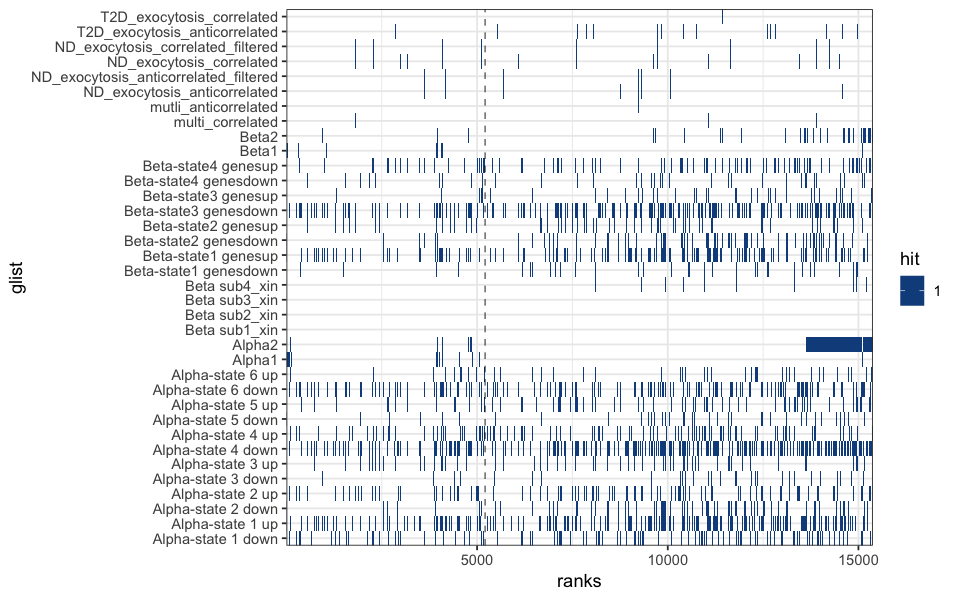

In [8]:
options(repr.plot.width = 8, repr.plot.height = 5)
pd <- pd.all %>% filter(celltype == "alpha")
ggplot(pd %>% filter(hit != 0), aes(ranks, glist)) + geom_raster(aes(fill = hit)) + geom_vline(size = 0.25, linetype = 2, xintercept = min(which((pd %>% 
    pull(mlog10P)) < 0))) + coord_cartesian(expand = F) + theme_bw() + theme(legend.key.width = unit(0.2, 
    "inch"), legend.key.height = unit(0.05, units = "inch"), panel.grid.minor.y = element_line(colour = "red")) + 
    scale_fill_gradient(low = "dodgerblue4", high = "dodgerblue4")

##### with ambious filter

In [64]:
prom.dat <- fread('../dat/figdata/fig2_prom_ttest_res_genelevel.csv')

pd.all <- do.call(rbind, lapply(rownames(glists), function(x) prom.dat %>% mutate(glist = x, 
    hit = ifelse(gene %in% as.character(glists[x, 3:ncol(glists)]), 1, 0)) %>% arrange(celltype, 
    desc(mlog10P))%>%filter(!isAmbious) %>% rowid_to_column("ranks")))
head(pd.all)
                                
(ranges <- sapply(c("alpha", "beta", "delta"), function(x) range(pd.all %>% filter(celltype == 
    x) %>% pull(ranks))))
pd.all <- pd.all %>% mutate(ranks = ifelse(celltype == "alpha", ranks, ifelse(celltype == 
    "beta", ranks - ranges[[1, "beta"]] + 1, ranks - ranges[[1, "delta"]] + 1))) 
sapply(c("alpha", "beta", "delta"), function(x) range(pd.all %>% filter(celltype == 
    x) %>% pull(ranks)))

ranks,celltype,gene,mlog10P,isAmbious,glist,hit
1,alpha,SPAG16,24.64232,FALSE,Beta1,1
2,alpha,GCG,24.33000,FALSE,Beta1,0
3,alpha,TTR,20.20129,FALSE,Beta1,0
4,alpha,TMEM72,19.73945,FALSE,Beta1,0
5,alpha,SEMA6A,17.92608,FALSE,Beta1,0
6,alpha,SND1,16.18444,FALSE,Beta1,0


alpha,beta,delta
1,13131,26119
13130,26118,38936


alpha,beta,delta
1,1,1
13130,12988,12818


In [120]:
require(ggpubr)
require(gridExtra)

In [138]:
options(repr.plot.width = 8, repr.plot.height = 7)

plotRanking <- function(ct = "alpha") {
    pd <- pd.all %>% filter(celltype == ct & !grepl("T2D", glist) & grepl(">10", 
        glist))
    labs <- levels(as.factor(pd$glist))
    ggplot(pd %>% filter(hit != 0) %>% mutate(glist2 = as.numeric(factor(glist))), 
        aes(ranks, glist)) + geom_segment(aes(xend = ranks, y = glist2 - 0.5, yend = glist2 + 
        0.5), size = 0.05, color = "dodgerblue4") + scale_y_continuous("glists", 
        breaks = 1:length(labs), labels = labs) + geom_hline(yintercept = seq(0.5, 
        length(unique(pd$glist)), by = 1), size = 0.5, color = "grey92") + geom_vline(size = 0.25, 
        linetype = 2, xintercept = min(which((pd %>% pull(mlog10P)) < 0))) + coord_cartesian(expand = F) + 
        theme_bw() + theme(panel.grid.minor.x = element_blank(), panel.grid.major = element_blank(), 
        legend.position = "none", )
}
p1 <- plotRanking("alpha")

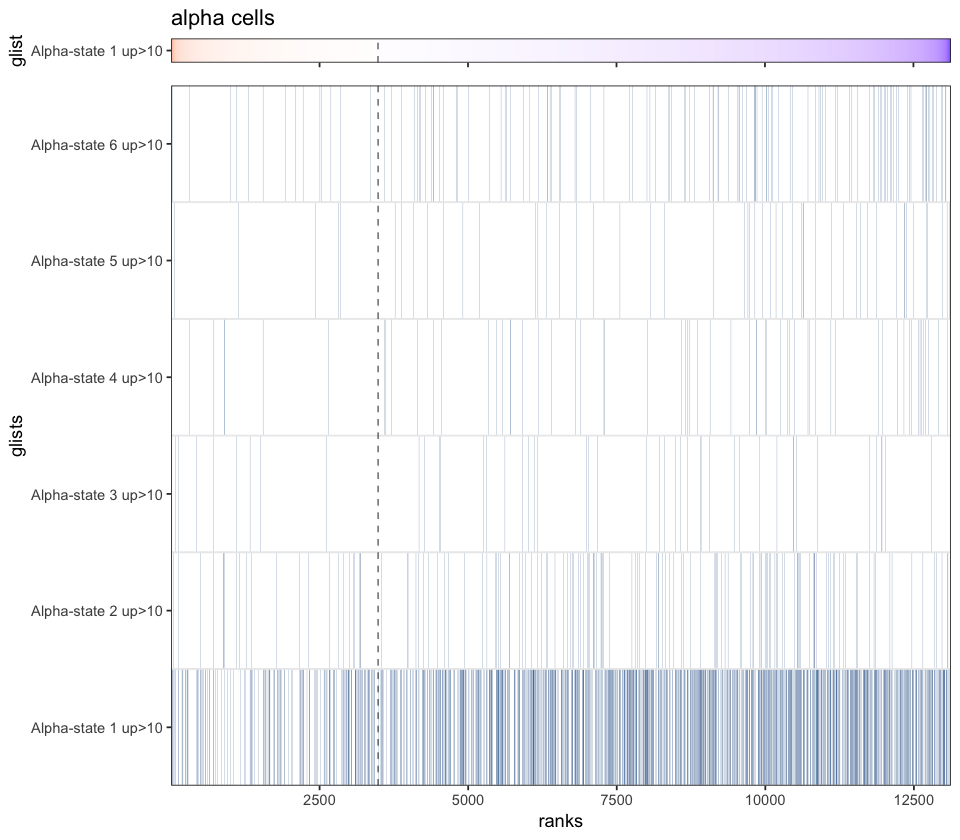

In [140]:
options(repr.plot.width = 8, repr.plot.height = 7)

plotRanking <- function(ct = "alpha") {
    pd <- pd.all %>% filter(celltype == ct & !grepl('T2D',glist) & grepl('>10',glist))
    labs <- levels(as.factor(pd$glist))
    p1 <- ggplot(pd %>% filter(hit != 0) %>% mutate(glist2 = as.numeric(factor(glist))), 
        aes(ranks, glist)) + geom_segment(aes(xend = ranks, y = glist2 - 0.5, yend = glist2 + 
        0.5), size = 0.05, color = "dodgerblue4") + scale_y_continuous("glists", 
        breaks = 1:length(labs), labels = labs) + geom_hline(yintercept = seq(0.5, 
        length(unique(pd$glist)), by = 1), size = 0.5, color = "grey92") + geom_vline(size = 0.25, 
        linetype = 2, xintercept = min(which((pd %>% pull(mlog10P)) < 0))) + coord_cartesian(expand = F) + 
        theme_bw() + theme(panel.grid.minor.x = element_blank(), panel.grid.major = element_blank(), 
        legend.position = "none", )
    p2 <- ggplot(pd %>% filter(glist == names(which.max(unlist(sapply(labs, nchar))))), 
        aes(ranks, glist)) + geom_raster(aes(fill = mlog10P)) + scale_fill_gradient2(high = "red", 
        low = "blue") + theme_bw() + coord_cartesian(expand = F) + theme(axis.text.x = element_blank(), 
        legend.position = "none", axis.title.x = element_blank()) + ggtitle(label = paste(ct, 
        "cells")) + geom_vline(size = 0.25, linetype = 2, xintercept = min(which((pd %>% 
        pull(mlog10P)) < 0)))
    grid.arrange(p2, p1, ncol = 1, heights = c(1,10))
}
plotRanking("alpha")

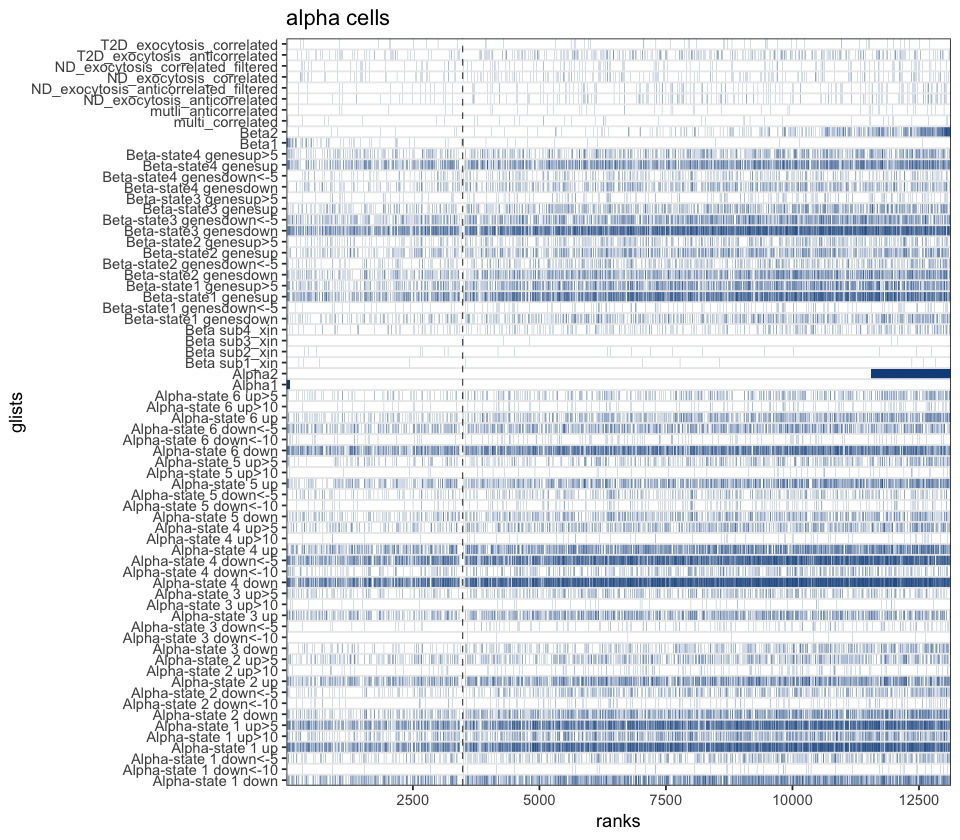

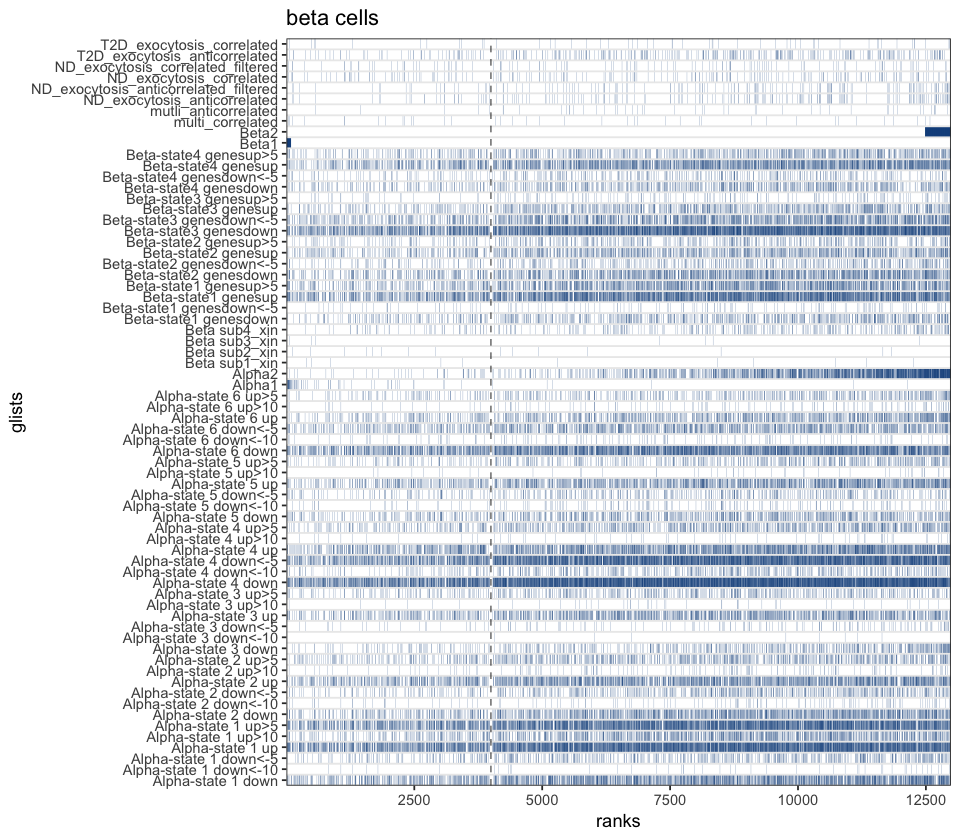

In [106]:
plotRanking('alpha')
plotRanking('beta')
#plotRanking('delta')

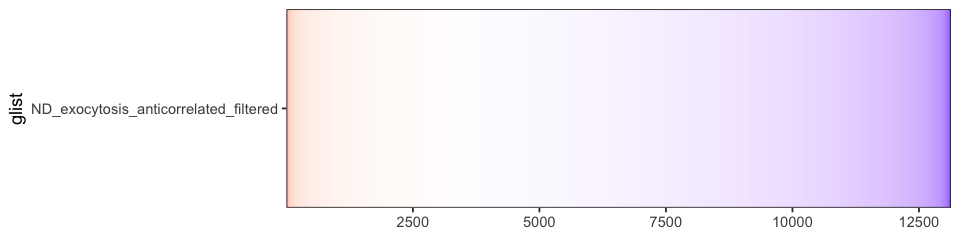

In [115]:
options(repr.plot.width = 8, repr.plot.height = 2)
